#### Project

# A descriptive study on patient factors that may influence attendance rates in a Brazilian clinic

## Table of contents
<ul>
<li><a href="#import">Imported modules, packages, and libraries</a></li>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data wrangling</a></li>
<li><a href="#eda">Exploratory data analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

> This dataset contains data from 100k medical appointments in Brazil and attempts to understand features which may influence patients' attendance to their scheduled medical appointments. It contains 14 variables, of which a number of characteristics about the patients are included.

>>* ‘ScheduledDay’ tells us on what day the patient set up their appointment.


>>* ‘Neighborhood’ indicates the location of the hospital.


>>* ‘Scholarship’ indicates whether or not the patient is enrolled in Brazilian welfare program Bolsa Família.


>>* ‘No-show’ uses ‘No’ if the patient showed up to their appointment, and ‘Yes’ if they did not show up.


>><a href="https://docs.google.com/document/d/e/2PACX-1vTlVmknRRnfy_4eTrjw5hYGaiQim5ctr9naaRd4V9du2B5bxpd8FEH3KtDgp8qVekw7Cj1GLk1IXdZi/pub?embedded=True">Database source</a>

## Objectives

To study if patient characteristics are different between patients with repeat visits vs patients with one time visits (unique visits).

To study if the time in days till the appointment is an important variable relative to patients' attendance. 

To study if patient characteristics correlate with the amount of time in days till the appointment.

## Questions explored

>**Question 1**
>>* How do patients age and days till appointment for unique visits differ relative to repeated visits?

>**Question 2**
>>* How is the distribution of days till the appointment for unique visits differ relative to repeated visits?

>**Question 3**
>>* Do the number of days till the appointment impact the attendance rates for unique visits differ relative to repeated visits?

>**Question 4**
>>* Does the patient age correlate with the difference in scheduling days till the appointment?

>**Question 5**
>>* Is the day of the appointment an important factor for the rate of attendance?


<a id='import'></a>
# Imported modules, packages and libraries 

In [35]:
import pandas as pd, numpy as np, seaborn as sns, matplotlib.pyplot as plt, matplotlib.cm as cm
from collections import Counter as co
from datetime import datetime
from scipy import stats, integrate
%matplotlib inline
sns.set(style="ticks", color_codes=True)

<a id='wrangling'></a>
## Data Wrangling


### General Properties

In [36]:
#Upload dataframe
df = pd.read_csv('noshowappointments-kagglev2-may-2016.csv')

In [37]:
#Display first few rows of uploaded dataframe
df.head(2)

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No


In [38]:
#Dataframe properties
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
PatientId         110527 non-null float64
AppointmentID     110527 non-null int64
Gender            110527 non-null object
ScheduledDay      110527 non-null object
AppointmentDay    110527 non-null object
Age               110527 non-null int64
Neighbourhood     110527 non-null object
Scholarship       110527 non-null int64
Hipertension      110527 non-null int64
Diabetes          110527 non-null int64
Alcoholism        110527 non-null int64
Handcap           110527 non-null int64
SMS_received      110527 non-null int64
No-show           110527 non-null object
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


In [39]:
#Number of unique values in each column
df.nunique()

PatientId          62299
AppointmentID     110527
Gender                 2
ScheduledDay      103549
AppointmentDay        27
Age                  104
Neighbourhood         81
Scholarship            2
Hipertension           2
Diabetes               2
Alcoholism             2
Handcap                5
SMS_received           2
No-show                2
dtype: int64

#### Interpretation 

> * The number of rows in the original dataframe are 110,527 and the number of columns 14.


> * There are no missing data


> * There are a total of 62,299 PatientId unique values. 


> * However, there are 110, 527 AppointmentID unique values. 


> * Therefore, there are multiple appointments from the same PatientId (repeated visits).



In [40]:
# To confirm if there are duplicate PatientId values, 
# we run a duplicate function on PatientId variable
sum(df.duplicated(subset="PatientId"))

48228

#### Interpretation 

> * There are 48,228 repeated PatientId values


In [41]:
# To check if the repeated PatientId's properties are changing over time
# we run a duplicate function on the original dataframe

sum(df.duplicated())

0

#### Interpretation 

> * Since there are no duplicate rows, it is likely that the patients are changing over time for the repeated visits (_this is only an exploratory test, not confirmatory_). 

In [42]:
#Create a dataframe only of repeated PatientIds (repeated visits)
# and a dataframe of only unique PatientIds visits (unique visits)
df_dup= df[df.duplicated(subset="PatientId")]
df_nondup = df.drop_duplicates(subset="PatientId");

#Filter dataframes for only adults
df_dup_adu = df_dup[df_dup["Age"] >= 18]
df_nondup_adu = df_nondup[df_nondup["Age"] >= 18];

#Drop handcap variable as it will not be part of the analysis
#and there is no descrption of how the variables are classified
#this will increase preformance
df_dup_adu.drop((["Handcap"]), axis = 1, inplace=True)
df_nondup_adu.drop((["Handcap"]), axis = 1, inplace=True);

#Create columns for schedule and appointment dates (this is a string which will be later converted to date value)
df_dup_adu['SchDate'] = df_dup_adu.ScheduledDay.apply(lambda x: x[:10])
df_dup_adu['AppDate'] = df_dup_adu.AppointmentDay.apply(lambda x: x[:10])
df_nondup_adu['SchDate'] = df_nondup_adu.ScheduledDay.apply(lambda x: x[:10])
df_nondup_adu['AppDate'] = df_nondup_adu.AppointmentDay.apply(lambda x: x[:10]);

#Convert string dates to date format
df_dup_adu['SchDateTime'] = pd.to_datetime(df_dup_adu['SchDate'])
df_dup_adu['AppDateTime'] = pd.to_datetime(df_dup_adu['AppDate'])
df_nondup_adu['SchDateTime'] = pd.to_datetime(df_nondup_adu['SchDate'])
df_nondup_adu['AppDateTime'] = pd.to_datetime(df_nondup_adu['AppDate']);

#Drop string date variables
df_dup_adu.drop((["SchDate"]), axis = 1, inplace=True)
df_dup_adu.drop((["AppDate"]), axis = 1, inplace=True)
df_nondup_adu.drop((["SchDate"]), axis = 1, inplace=True);
df_nondup_adu.drop((["AppDate"]), axis = 1, inplace=True);

#Create a column for the amount of days till the appointment date
df_dup_adu['DiffDates'] = (df_dup_adu['AppDateTime'] - df_dup_adu['SchDateTime']).dt.days 
df_nondup_adu['DiffDates'] = (df_nondup_adu['AppDateTime'] - df_nondup_adu['SchDateTime']).dt.days;

#Create a column for the day of the week
df_dup_adu['Weekday'] = df_dup_adu['AppDateTime'].dt.weekday_name
df_nondup_adu['Weekday'] = df_nondup_adu['AppDateTime'].dt.weekday_name

#Create data frames for the repeat visits dataframes 
#and the unique visits dataframes
df1= df_dup_adu #repeat visits dataframe
df2= df_nondup_adu  #unique visits dataframe 

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarni

In [43]:
#Test df1 
df1.head(1)

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,SMS_received,No-show,SchDateTime,AppDateTime,DiffDates,Weekday
154,1.925263e+10,5636933,F,2016-04-28T16:38:34Z,2016-04-29T00:00:00Z,30,ITARARÉ,0,0,0,0,0,No,2016-04-28,2016-04-29,1,Friday


In [44]:
#Test df2
df2.head(1)

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,SMS_received,No-show,SchDateTime,AppDateTime,DiffDates,Weekday
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,No,2016-04-29,2016-04-29,0,Friday


<a id='eda'></a>
## Exploratory Data Analysis


### How do  age and days till appointment for unique visit patients differ versus repeat visits patients?

In [45]:
#Check the central tendencies of age and time till the appointment 
#for the repeated visits in the next two cells
df1.iloc[:, np.r_[5:6, 15:16]].describe()

,Age,DiffDates
count,37110.000000,37110.000000
mean,46.561358,9.061870
std,17.370401,13.908177
min,18.000000,-6.000000
25%,32.000000,0.000000
50%,46.000000,4.000000
75%,59.000000,13.000000
max,115.000000,179.000000


In [46]:
#Check the median of age and time till the appointment 
#for the repeated visits
df1.iloc[:, np.r_[5:6, 15:16]].median()

Age          46.0
DiffDates     4.0
dtype: float64

In [47]:
#Check the central tendencies of age and time till the appointment 
#for the unique visits in the next two cells
df2.iloc[:, np.r_[5:6, 15:16]].describe()

,Age,DiffDates
count,46037.00000,46037.000000
mean,47.15027,11.431023
std,17.90738,17.004354
min,18.00000,0.000000
25%,32.00000,0.000000
50%,47.00000,4.000000
75%,60.00000,17.000000
max,115.00000,179.000000


In [48]:
#check the median of age and time till the appointment 
#for the repeated visits
df2.iloc[:, np.r_[5:6, 15:16]].median()

Age          47.0
DiffDates     4.0
dtype: float64

#### Results 

The mean(±SD) results

**Repeated visits**

46.56(±17.37) years of age.

9.06(±13.90) days till appointment

**Unique visits**

47.15(±17.90) years of age.

11.43(±17.004354) days till appointment

#### Interpretation

> * The difference between the mean and median across both dataframes is not substantial.


> * The difference between the mean(±SD) age between the dataframes does not seem substantial



> * The difference between the mean(±SD) days till the appointment may be substantial from the exploratory analysis, suggesting that that unique visits schedule their appointment dates at a longer period. 

### How is the distribution of days till the appointment for unique visit patients versus repeat visits patients?

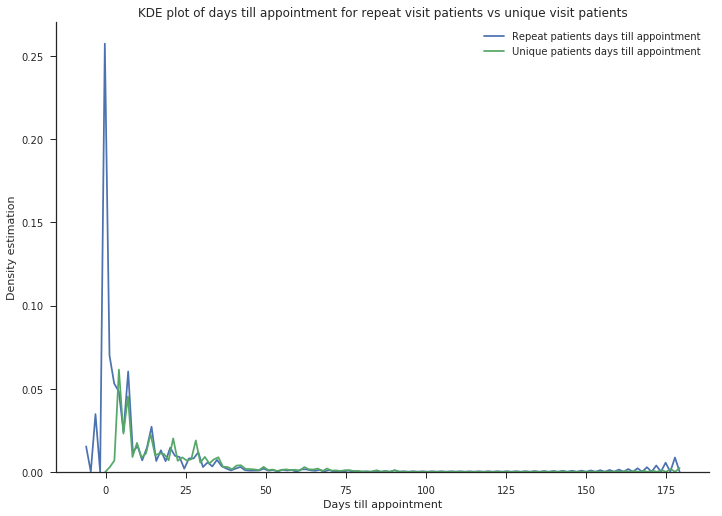

In [49]:
#I use a kernel density estimation (KDE) to plot the distribution of the 
# days till appointment to visually compare between the repeated 
# and unique visits

a4_dims = (11.7, 8.27)
fig, x = plt.subplots(figsize=a4_dims)
y= df1["DiffDates"]
z= df2["DiffDates"]
ax= sns.kdeplot(y, bw=.05, label="Repeat patients days till appointment").set_title('KDE plot of days till appointment for repeat visit patients vs unique visit patients')
ag= sns.kdeplot(z, bw=.05, label="Unique patients days till appointment")
plt.ylabel('Density estimation');
plt.xlabel('Days till appointment')
sns.despine();

###### This analysis is to observe the difference in distribution in days till appointment between repeat visit patients and unique visit patients which corresponds to question 2 in this project

#### Interpretation

> * The KDE graph suggests that that unique visits plan their visits for a later date than repeat visit patients. (i.e. the green line zeneth is at a higher number on the x-axis compared to the blue line zeneth).


### Do the number of days till the appointment impact the attendance rates for unique visit patients versus repeat visits patients?

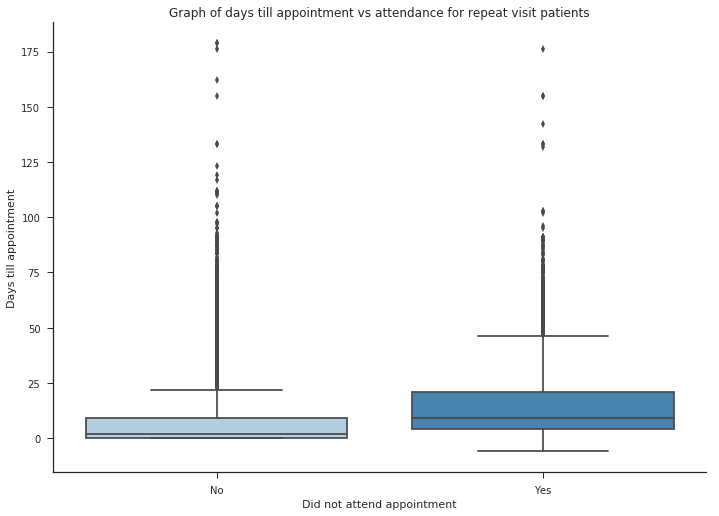

In [50]:
#Now I want to see if the later visits 
#translate into more no shows or less no shows.
#to do this I inspect the data visually.

a4_dims = (11.7, 8.27)
fig, x = plt.subplots(figsize=a4_dims)
ax = sns.boxplot(x="No-show", y="DiffDates", data=df1, palette="Blues").set_title('Graph of days till appointment vs attendance for repeat visit patients')
plt.ylabel('Days till appointment');
plt.xlabel('Did not attend appointment')
sns.despine();


###### This analysis is  to observe if there is a difference in number of days till appointment between patients which attend visits versus patients which did not attend their visits in the repeated visit patient group

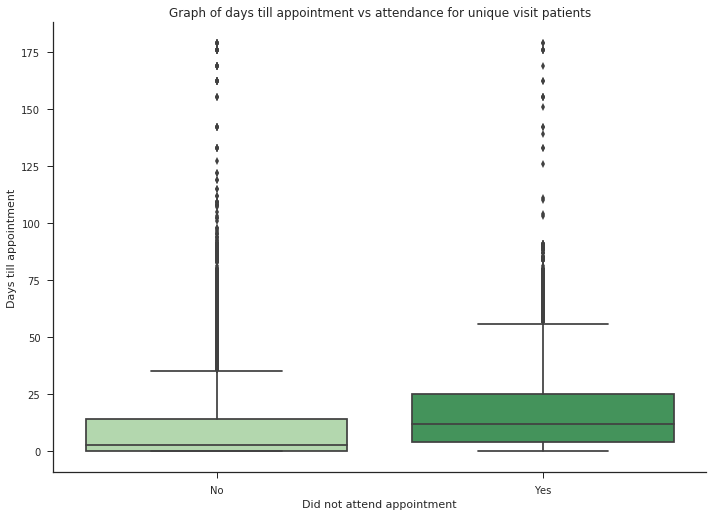

In [51]:
a4_dims = (11.7, 8.27)
fig, x = plt.subplots(figsize=a4_dims)
sns.boxplot(x="No-show", y="DiffDates", data=df2, palette="Greens").set_title('Graph of days till appointment vs attendance for unique visit patients')
plt.ylabel('Days till appointment');
plt.xlabel('Did not attend appointment')
sns.despine();

###### This visualization is to observe if there is a difference in number of days till appointment between patients which attend visits versus patients which did not attend their visits in the unique visit patient group

#### Interpretation

> * It seems that later scheduled visits are less likely to attend their visits in both groups(i.e the further the appointment date from the scheduled data, the less likely the patient will attend).


> * However, visually it is difficult to determine if repeated visit patients vs unique visits have more/less no-shows relative to their appointment scheduling patterns. Therefore we use the group by function to inspect this assumption further. Also by using central tendency values we can appreciate the numeric difference in date scheduling times/patterns.

In [52]:
# By using the describe function we look at central tendency values for the repeat visit patients 
df1.groupby(["No-show"]) ["DiffDates"].describe()

,count,mean,std,min,25%,50%,75%,max
No-show,,,,,,,,
No,29622.0,7.704476,13.099432,0.0,0.0,2.0,9.0,179.0
Yes,7488.0,14.431624,15.612507,-6.0,4.0,9.0,21.0,176.0


In [53]:
# By using the describe function we look at central tendency values for the repeat visit patients 
df1.groupby(["No-show"]) ["DiffDates"].median()

No-show
No     2
Yes    9
Name: DiffDates, dtype: int64

In [54]:
#Then we look at the unique visit patients
df2.groupby(["No-show"]) ["DiffDates"].describe()

,count,mean,std,min,25%,50%,75%,max
No-show,,,,,,,,
No,37203.0,10.095234,16.459486,0.0,0.0,3.0,14.0,179.0
Yes,8834.0,17.056486,18.077881,0.0,4.0,12.0,25.0,179.0


In [55]:
df2.groupby(["No-show"]) ["DiffDates"].median()

No-show
No      3
Yes    12
Name: DiffDates, dtype: int64

#### Interpretation

> * It seems as though for both types of no-shows the unique visit patients schedule their appointments with a longer period of time.


> * Interestingly we also observe that patients who do not attend their visits have almost double the average amount of days scheduled for their appointment dates in relation to the patients which did attend their visits. 


> * When we look at the median tendency we observe that the data is substantially skewed and also that the proportional difference in days is over 300% greater in both visit types between attendees vs non-attendees.

### Does the patient age correlate with the difference in scheduling days till the appointment for unique visit patients versus repeat visits patients?

**To further explore variables that may affect the difference in date scheduling, we will also look at age.** 

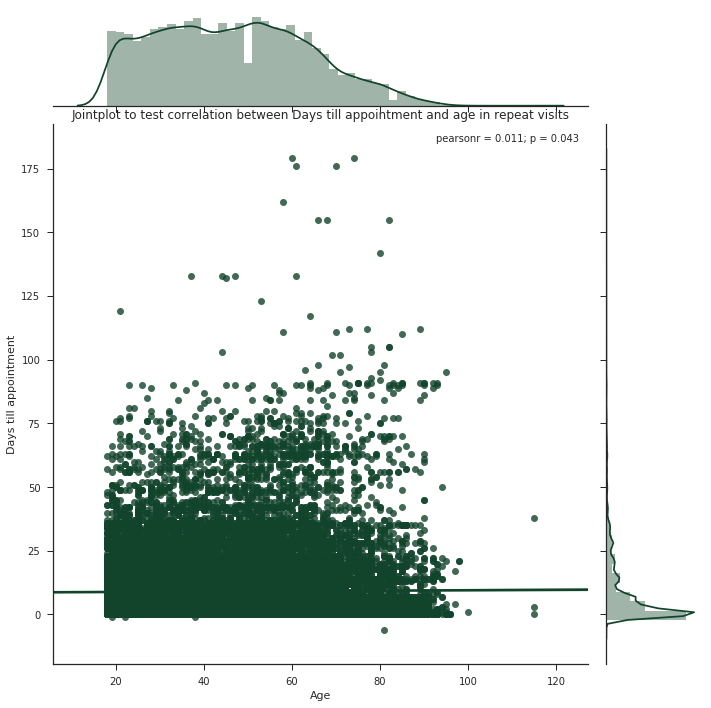

In [56]:
sns.set(style="ticks")
with sns.diverging_palette(145, 280, s=85, l=25, n=7):
    ax = sns.jointplot(x="Age", y="DiffDates", kind="reg", data=df1, size=10)
    plt.title('Jointplot to test correlation between Days till appointment and age in repeat visits')
    plt.ylabel('Days till appointment');

###### Since it seems that the number of days till the appointment is an important covariate in determining if a patient attends a visit or not, I then wanted to determine if the patient's age also potentially affected this variable (i.e. days till appointment). Therefore I ran a correlation in both groups (the graph below was ran for the same reason). 

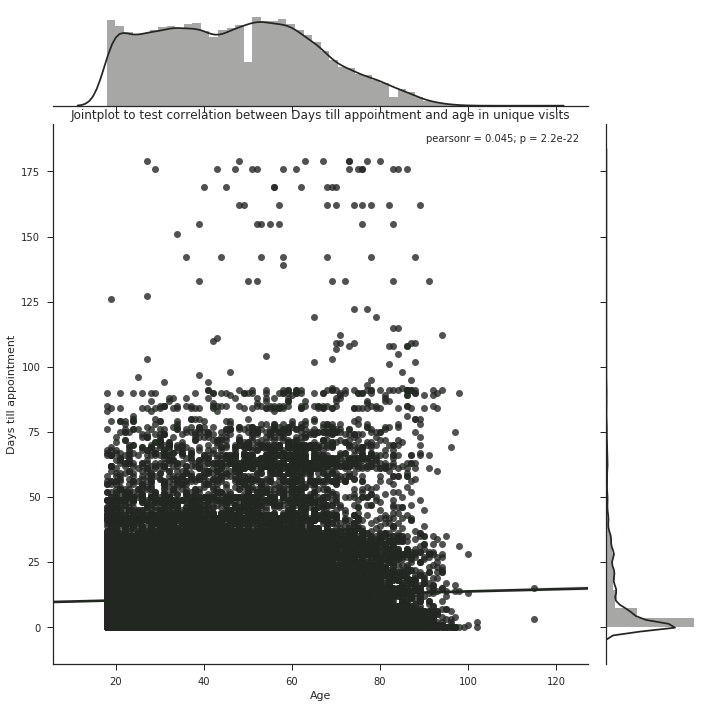

In [57]:
sns.set(style="ticks")
with sns.diverging_palette(115, 281, s=15, l=15, n=7):
    sns.jointplot(x="Age", y="DiffDates", kind="reg", data=df2, size=10)
    plt.title('Jointplot to test correlation between Days till appointment and age in unique visits')
    plt.ylabel('Days till appointment');

#### Interpretation

> * It seems that age is not an important variable for determining the days till the appointment, and therefore may not be an important factor for determining attendence in the adult population (this is suggested by pearson's R^2 result which is low).

### Is the day of the appointment an important factor for the rate of attendance for unique visit patients versus repeat visits patients??

I also wanted to explore if the weekday could be a point of interest for determining when to schedule patients to reduce the number of non attended visits. 

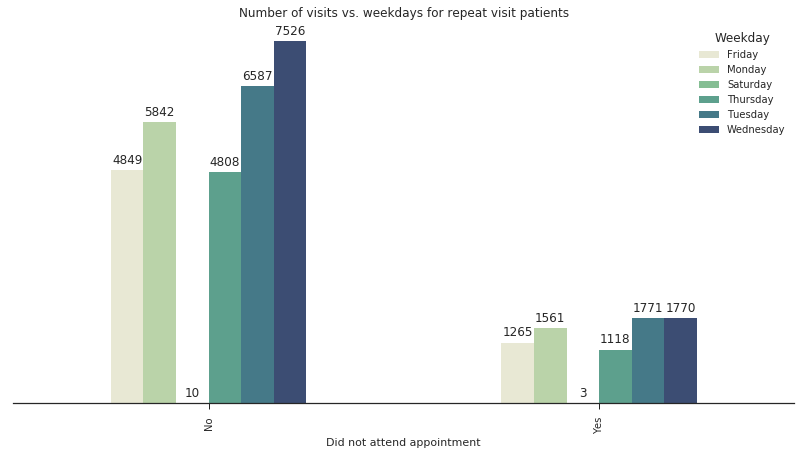

In [58]:
ag = df1.groupby('No-show').Weekday.value_counts().sort_index()
ag.unstack().sort_index()
sns.set(style="ticks", color_codes=True)

with sns.cubehelix_palette(6, start=0.5, rot=-0.75, dark=0.3, light=0.9, reverse=False):
    ax = ag.unstack().plot(kind='bar', subplots=False, layout=(2,3), figsize=(14, 7), sort_columns=True, title="Number of visits vs. weekdays for repeat visit patients", legend=True,table=False, stacked=False, yticks=[])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_xlabel("Did not attend appointment")
    for p in ax.patches: 
        ax.annotate(np.round(p.get_height(),decimals=2), (p.get_x()+p.get_width()/2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')



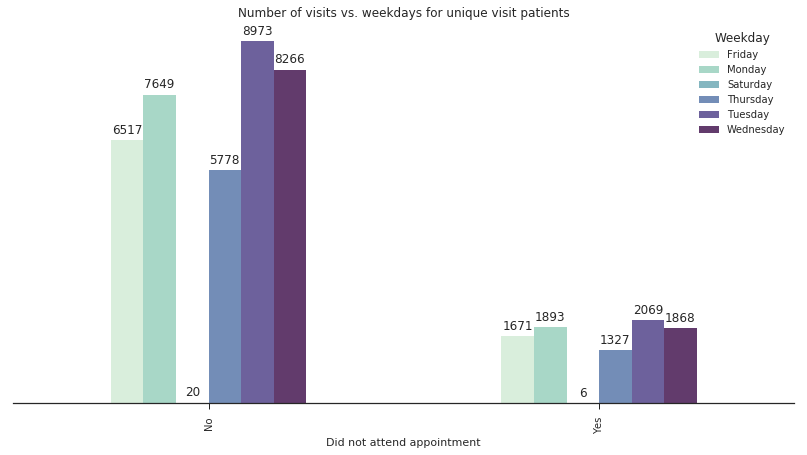

In [59]:
ag = df2.groupby('No-show').Weekday.value_counts().sort_index()
ag.unstack().sort_index()
sns.set(style="ticks", color_codes=True)

with sns.cubehelix_palette(6, start=1.0, rot=-0.75, dark=0.3, light=0.9, reverse=False):
    ax = ag.unstack().plot(kind='bar', subplots=False, layout=(2,3), figsize=(14, 7), sort_columns=True, title="Number of visits vs. weekdays for unique visit patients", legend=True,table=False, stacked=False, yticks=[])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_xlabel("Did not attend appointment")
    for p in ax.patches: 
        ax.annotate(np.round(p.get_height(),decimals=2), (p.get_x()+p.get_width()/2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')



#### Interpretation

> * It seems that the day of the week may not be a relevant variable to consider when scheduling patients (other than weekends) as the days with the most amount of missed appointments are also the days with the most visits. 


> * One possible lesson here is that there may be over scheduling as the number of attended visits seem to coincide with the number of missed visits. 




<a id='conclusions'></a>
## Conclusions

1)  This is a descriptive analysis and any conclusions are not conclusive (i.e the results here may suggest tendencies and need to be confirmed via further inferential analysis). In addition, one should not only use univariate models, however one should consider the multiple covariates in the provided dataframes. Therefore to come up with a more concrete conclusion univariate and multivariate models with inferential statistics will have to be used. However, this is not the objective of the current project. 

2) There does not seem to be a difference in age between patients with repeat visits versus unique visits. However, the time in days till their appointment seems to be different between these groups. However, this can only be confirmed by running a Students t-test/univariate linear regression model.

3) There seems to be a relationship between the attendence rate of patients and the time till their appointment (i.e the difference in days between the moment of scheduling the appointment and the actual date of the appointment). 

4) Repeat visit patients have a shorter period of time between scheduling and attending their appointments, relative to unique visits. 

5) The patient age does not seem to correlate with number of days till the appointment.

6) In general the day of the appointment does not seem to be a substantially important factor in determining attendence rates (however it was noted that weekends had very low scheduling rates).

# Summary

The number of days till the appointment seems to be an important covariate for determining if patients attend their medical visit. Also if the patient has previously attended a medical appointment, seens to determine the duration of the number of days in which they schedule their appointments (repeat visit patients schedule their appointments in a shorter period than unique visit patients). This is important since the higher the number of days till the appointment a visit is scheduled seems to impact a patient's attendance. The age and day of weeks seems to be less relevant covariates in determining scheduling habits and attendance. However the previous can only be confirmed with inferential statistics (i.e. multivariate modeling). 

**Weblink references**

https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.plot.html

https://seaborn.pydata.org/tutorial/color_palettes.html

http://themrmax.github.io/2015/11/13/grouped-histograms-for-categorical-data-in-pandas.html

https://stackoverflow.com/questions/925024/how-can-i-remove-the-top-and-right-axis-in-matplotlib

https://stackoverflow.com/questions/25447700/annotate-bars-with-values-on-pandas-bar-plots

https://stackoverflow.com/questions/31594549/how-do-i-change-the-figure-size-for-a-seaborn-plot/31597278

In [60]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Investigate_a_Dataset.ipynb'])

0